# Carregando os Dados

In [0]:
from google.colab import drive

drive.mount('/content/drive')     

# clicar na url, entrar numa conta gmail, copiar o código e colar abaixo

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd

resenha = pd.read_csv('/content/drive/My Drive/imdb-reviews-pt-br.csv')   # arquivo que ja foi feito upload no google drive

resenha.tail()

,id,text_en,text_pt,sentiment
49454,49456,"Seeing as the vote average was pretty low, and...","Como a média de votos era muito baixa, e o fat...",pos
49455,49457,"The plot had some wretched, unbelievable twist...",O enredo teve algumas reviravoltas infelizes e...,pos
49456,49458,I am amazed at how this movieand most others h...,Estou espantado com a forma como este filme e ...,pos
49457,49459,A Christmas Together actually came before my t...,A Christmas Together realmente veio antes do m...,pos
49458,49460,Working-class romantic drama from director Mar...,O drama romântico da classe trabalhadora do di...,pos


# Separando os Dados (Treino e Teste)

In [0]:
from sklearn.model_selection import train_test_split
treino, teste, classe_treino, classe_teste = train_test_split(resenha.text_pt, 
                                                              resenha.sentiment, 
                                                              random_state = 42)
# text_pt é o conjunto X e o sentiment é o conjunto Y
print(treino.head())  # X (features)
print(classe_treino.head()) # Y (labels)


1348     Embora o filme tenha sido apenas assim, o clos...
27466    Este é provavelmente um dos piores filmes que ...
29998    De vez em quando, um filme irá varrer ao seu r...
48186    Este é um conto completamente diabólico de quã...
26473    Lenta, chata, extremamente repetitiva. Não adm...
Name: text_pt, dtype: object
1348     neg
27466    neg
29998    neg
48186    pos
26473    neg
Name: sentiment, dtype: object


# Tentando Treinar

**Forma errada, pois este modelo não interpreta dados textuais**

In [0]:
''' Comentando em varias linhas com 3 aspas simples, no início e no fim

   from sklearn.linear_model import LogisticRegression

   regressao_logistica = LogisticRegression()  
    modelo = regressao_logistica.fit(treino, classe_treino)    
    acuracia = regressao_logistica.fit(teste, classe_teste) 
    
'''

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: ignored

# Tratamento dos Dados

In [0]:
print(resenha.sentiment.value_counts())  # retorna a quantidade total de classificação positiva e negativa

# percebe-se que os dados estão balanceados, ou seja, quantidades proximas de resenhas positivas e negativas

neg    24765
pos    24694
Name: sentiment, dtype: int64


In [0]:
# Cria uma coluna para substituir neg e pos para 0 e 1

classificacao = resenha['sentiment'].replace(['neg','pos'],[0,1])
resenha['classificacao'] = classificacao
resenha.tail()

,id,text_en,text_pt,sentiment,classificao,classificacao
49454,49456,"Seeing as the vote average was pretty low, and...","Como a média de votos era muito baixa, e o fat...",pos,1,1
49455,49457,"The plot had some wretched, unbelievable twist...",O enredo teve algumas reviravoltas infelizes e...,pos,1,1
49456,49458,I am amazed at how this movieand most others h...,Estou espantado com a forma como este filme e ...,pos,1,1
49457,49459,A Christmas Together actually came before my t...,A Christmas Together realmente veio antes do m...,pos,1,1
49458,49460,Working-class romantic drama from director Mar...,O drama romântico da classe trabalhadora do di...,pos,1,1


# Bag of Words e Matriz Esparsa


**Exemplo simples**

In [0]:
# Transforma cada palavra das resenhas em um elemento de vetor

from sklearn.feature_extraction.text import CountVectorizer

texto = ["Assisti um filme ótimo", "Assisti um filme ruim"]

vetorizar = CountVectorizer(lowercase=False)
bag_of_words = vetorizar.fit_transform(texto)

vetorizar.get_feature_names()

['Assisti', 'filme', 'ruim', 'um', 'ótimo']

In [0]:
bag_of_words   # é uma matriz esparsa

<2x5 sparse matrix of type '<class 'numpy.int64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [0]:
# utilizar o SparseDataFrame quando quiser transformar uma matriz esparsa em um DF

matriz_esparsa = pd.SparseDataFrame(bag_of_words,           
                      columns=vetorizar.get_feature_names())

matriz_esparsa



,Assisti,filme,ruim,um,ótimo
0,1,1,NaN,1,1.0
1,1,1,1.0,1,NaN


**Agora com o conjunto de dados do IMDB**

In [0]:
vetorizar = CountVectorizer(lowercase=False, max_features=50)   # como são muitas palavras, limita para 50 palavras mais importantes
bag_of_words = vetorizar.fit_transform(resenha.text_pt)   # transforma em vetor
print(bag_of_words.shape)

(49459, 50)


**Função para Classificar Sentimentos com Regressão Logistica**

In [0]:
def classificar_texto(texto, coluna_texto, coluna_classificacao):
    vetorizar = CountVectorizer(lowercase=False, max_features=50)
    bag_of_words = vetorizar.fit_transform(texto[coluna_texto])
    treino, teste, classe_treino, classe_teste = train_test_split(bag_of_words,
                                                              texto[coluna_classificacao],
                                                              random_state = 42)
    regressao_logistica = LogisticRegression(solver = "lbfgs")
    regressao_logistica.fit(treino, classe_treino)
    return regressao_logistica.score(teste, classe_teste)
print(classificar_texto(resenha, "text_pt", "classificacao"))


0.6583097452486858


# Visualizando os dados com WordCloud
**WordCloud destaca as palavras que aparecem com maior frequência**

In [0]:
!pip install wordcloud

In [0]:
# primeiro cria o objeto (nuvem_palavras)

%matplotlib inline

from wordcloud import WordCloud

todas_palavras = ' '.join([texto for texto in resenha.text_pt])  # uma lista com as resenhas e separando as palavras por espaço

nuvem_palvras = WordCloud(width= 800, height= 500,   # define a largura e a altura das palavras
                          max_font_size = 110,       # define a fonte máxima das palavras
                          collocations = False).generate(todas_palavras)  # collocations = False retira o cálculo das frequências dos bigramas (duas palavras juntas)
                                                                          # Ex. de bigramas: Em vez de analisarmos as palavras separadamente, analisamos em pares. 
                                                                          # Então, em vez de "um" e "filme", analisamos "um filme"

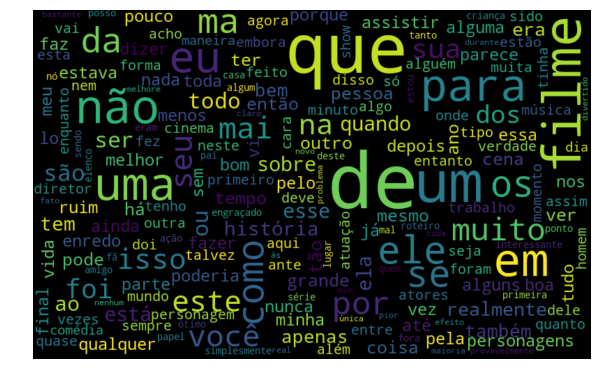

In [0]:
# pega o objeto criado e o transforma em uma imagem com o matplotlib

import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))   # largura da imagem
plt.imshow(nuvem_palvras, interpolation='bilinear')   # o parâmetro interpolation='bilinear' melhora a nitidez da imagem
plt.axis("off")  # retira a numeração dos eixos
plt.show()

# percebe-se que WordCloud elimina diversas stopwords

**Função que retorne nuvem de palavras negativas**

In [0]:
def nuvem_palavras_neg(texto, coluna_texto):
    texto_negativo = texto.query("sentiment == 'neg'")   # faz um filtro com o método query, para retornar apenas sentimentos negativos
    todas_palavras = ' '.join([texto for texto in texto_negativo[coluna_texto]]) # passa o texto negativo criado anteriormente

    nuvem_palvras = WordCloud(width= 800, height= 500,
                              max_font_size = 110,
                              collocations = False).generate(todas_palavras)
    plt.figure(figsize=(10,7))
    plt.imshow(nuvem_palvras, interpolation='bilinear')
    plt.axis("off")
    plt.show()

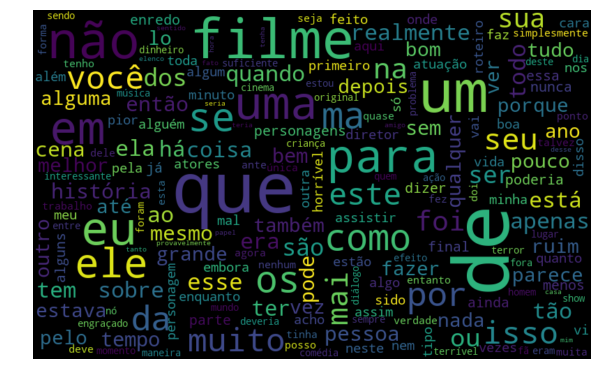

In [0]:
nuvem_palavras_neg(resenha, "text_pt")

**Função que retorne nuvem de palavras positivas**

In [0]:
# mesmo procedimento do outro, porem com sentimentos positivos

def nuvem_palavras_pos(texto, coluna_texto):
    texto_positivo = texto.query("sentiment == 'pos'")
    todas_palavras = ' '.join([texto for texto in texto_positivo[coluna_texto]])

    nuvem_palvras = WordCloud(width= 800, height= 500,
                              max_font_size = 110,
                              collocations = False).generate(todas_palavras)
    plt.figure(figsize=(10,7))
    plt.imshow(nuvem_palvras, interpolation='bilinear')
    plt.axis("off")
    plt.show()

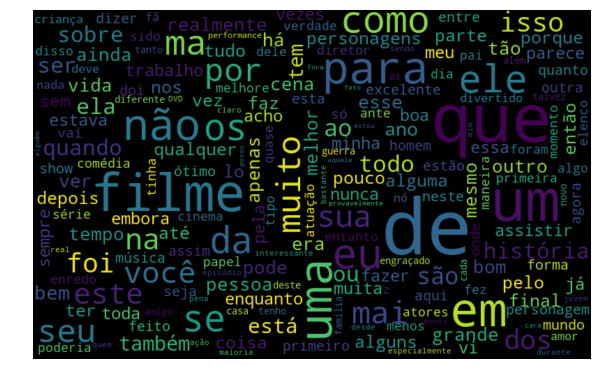

In [0]:
nuvem_palavras_pos(resenha, "text_pt")

# Tokenização e a bliblioteca NLTK
 **NLTK - Natural Language Tool Kit**

In [0]:
import nltk

nltk.download('all')  # também poderia especificar alguma biblioteca específica do nltk, para nao precisar baixar tudo

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

In [0]:
frase = ["um filme bom", "um filme ruim"]
frequencia = nltk.FreqDist(frase)  
frequencia

# porem não mostra a frequência de cada palavra, precisa antes separa-las

FreqDist({'um filme bom': 1, 'um filme ruim': 1})

In [0]:
# processo de criar tokens e separar cada palavra da nossa frase se chama Tokenização

from nltk import tokenize   # importa o tokenise do nltk

frase = "Bem vindo ao mundo do PLN!"

token_espaco = tokenize.WhitespaceTokenizer()  # chama a função que separa cada palavra por espaço em branco (pode utilizar outro tipo de separação)
token_frase = token_espaco.tokenize(frase) # usa na frase criada
print(token_frase)

['Bem', 'vindo', 'ao', 'mundo', 'do', 'PLN!']


**Aplicando no conjunto de dados das resenhas dos filmes**

In [0]:
token_frase = token_espaco.tokenize(todas_palavras)
frequencia = nltk.FreqDist(token_frase)
df_frequencia = pd.DataFrame({"Palavra": list(frequencia.keys()), # transforma em DF, e retorna apenas as chaves do dicionario
                                   "Frequência": list(frequencia.values())}) # retorna os valores do dicionario

In [0]:
df_frequencia.nlargest(columns = "Frequência", n = 10)  

# nlargest ordena a coluna desejada (Frequência) e a quantidade de palavras(n = 10) com maiores frequências

,Palavra,Frequência
20,de,417651
14,que,325070
42,e,299743
3,o,244881
7,um,216410
102,a,210179
45,é,192381
200,em,132778
1,uma,130888
29,não,127915


# Grafico de Pareto - Criação e Exploração

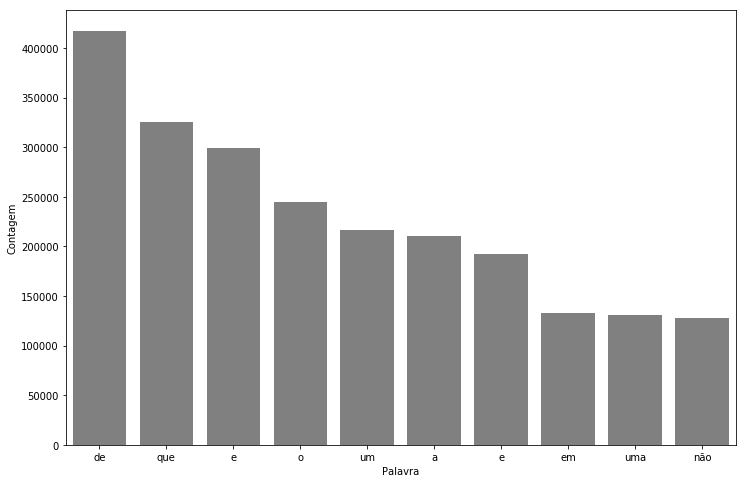

In [0]:
import seaborn as sns

# função que retorna o gráfico de pareto
    
def pareto(texto, coluna_texto, quantidade):
    todas_palavras = ' '.join([texto for texto in texto[coluna_texto]])
    token_frase = token_espaco.tokenize(todas_palavras)
    frequencia = nltk.FreqDist(token_frase)
    df_frequencia = pd.DataFrame({"Palavra": list(frequencia.keys()),
                                   "Frequência": list(frequencia.values())})
    df_frequencia = df_frequencia.nlargest(columns = "Frequência", n = quantidade)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequencia, x = "Palavra", y = "Frequência", color = 'gray')
    ax.set(ylabel = "Contagem")
    plt.show()



pareto(resenha, "text_pt", 10)  # 10 palavras mais frequentes

# Stop Words - Palavras Irrelevantes

In [0]:
palavras_irrelevantes = nltk.corpus.stopwords.words("portuguese")   # chama a função de stopwords da lingua portuguesa

# faz um filtro para retirar todas as stopwords, como: a, e, de, que, o, um, etc.
frase_processada = list()
for opiniao in resenha.text_pt:
    nova_frase = list()
    palavras_texto = token_espaco.tokenize(opiniao)
    for palavra in palavras_texto:
        if palavra not in palavras_irrelevantes:
            nova_frase.append(palavra)
    frase_processada.append(' '.join(nova_frase))
    
resenha["tratamento_1"] = frase_processada    # cria uma coluna com as resenhas depois de serem filtradas as stopwords

In [0]:
resenha.head()

,id,text_en,text_pt,sentiment,classificao,classificacao,tratamento_1
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg,0,0,"Mais vez, Sr. Costner arrumou filme tempo nece..."
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg,0,0,Este exemplo motivo maioria filmes ação mesmos...
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg,0,0,"Primeiro tudo odeio raps imbecis, poderiam agi..."
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg,0,0,Nem Beatles puderam escrever músicas todos gos...
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg,0,0,"Filmes fotos latão palavra apropriada eles, ve..."


In [0]:
classificar_texto(resenha, "tratamento_1", "classificacao")  # classifica baseado na coluna tratamento

0.6607359482410028

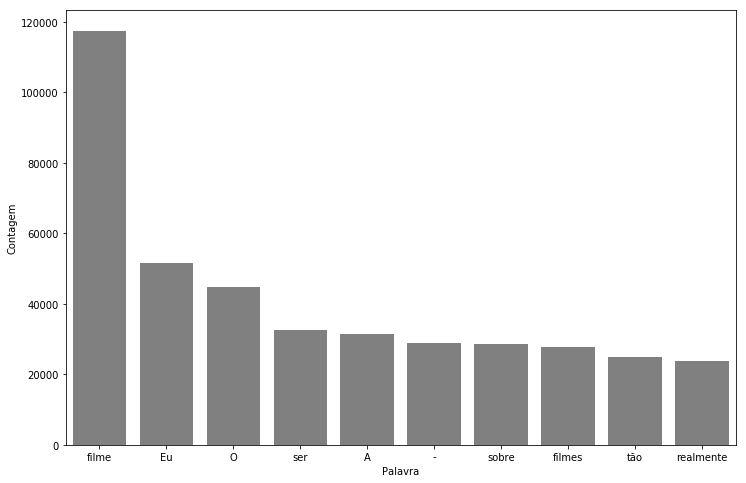

In [0]:
pareto(resenha,"tratamento_1", 10)  # gráfico de pareto baseado na coluna tratamento

# Melhorando a visualização do pareto
 **Separando e Removendo a Pontuação** 

In [0]:
# exemplo simples

frase = "Olá mundo!"
token_pontuacao = tokenize.WordPunctTokenizer()   # separando a pontuação das palavras
token_frase = token_pontuacao.tokenize(frase)

print(token_frase)

['Olá', 'mundo', ',', 'olá', '!']


In [0]:
from string import punctuation

pontuacao = list()
for ponto in punctuation:
    pontuacao.append(ponto)

pontuacao_stopwords = pontuacao + palavras_irrelevantes  # alem de remover palavras irrelevantes remove a pontuação

frase_processada = list()
for opiniao in resenha["tratamento_1"]:
    nova_frase = list()
    palavras_texto = token_pontuacao.tokenize(opiniao)
    for palavra in palavras_texto:
        if palavra not in pontuacao_stopwords:
            nova_frase.append(palavra)
    frase_processada.append(' '.join(nova_frase))
    
resenha["tratamento_2"] = frase_processada   # outra coluna de tratamento

In [0]:
resenha.head()

,id,text_en,text_pt,sentiment,classificao,classificacao,tratamento_1,tratamento_2
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg,0,0,"Mais vez, Sr. Costner arrumou filme tempo nece...",Mais vez Sr Costner arrumou filme tempo necess...
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg,0,0,Este exemplo motivo maioria filmes ação mesmos...,Este exemplo motivo maioria filmes ação mesmos...
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg,0,0,"Primeiro tudo odeio raps imbecis, poderiam agi...",Primeiro tudo odeio raps imbecis poderiam agir...
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg,0,0,Nem Beatles puderam escrever músicas todos gos...,Nem Beatles puderam escrever músicas todos gos...
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg,0,0,"Filmes fotos latão palavra apropriada eles, ve...",Filmes fotos latão palavra apropriada verdade ...


In [0]:
resenha["tratamento_1"][0]

'Mais vez, Sr. Costner arrumou filme tempo necessário. Além terríveis seqüências resgate mar, quais poucas, simplesmente importei nenhum personagens. A maioria fantasmas armário, personagem Costers realizado logo início, esquecido tarde, importava. O personagem deveríamos importar arrogante superconfiante, Ashton Kutcher. O problema sai garoto pensa melhor qualquer outra pessoa redor mostra sinais armário desordenado. Seu único obstáculo parece estar vencendo Costner. Finalmente, bem além meio caminho, Costner conta sobre fantasmas Kutchers. Somos informados Kutcher levado ser melhor pressentimentos presságios anteriores. Nenhuma mágica aqui, tudo podia fazer desligar hora.'

In [0]:
resenha["tratamento_2"][0]

'Mais vez Sr Costner arrumou filme tempo necessário Além terríveis seqüências resgate mar quais poucas simplesmente importei nenhum personagens A maioria fantasmas armário personagem Costers realizado logo início esquecido tarde importava O personagem deveríamos importar arrogante superconfiante Ashton Kutcher O problema sai garoto pensa melhor qualquer outra pessoa redor mostra sinais armário desordenado Seu único obstáculo parece estar vencendo Costner Finalmente bem além meio caminho Costner conta sobre fantasmas Kutchers Somos informados Kutcher levado ser melhor pressentimentos presságios anteriores Nenhuma mágica aqui tudo podia fazer desligar hora'

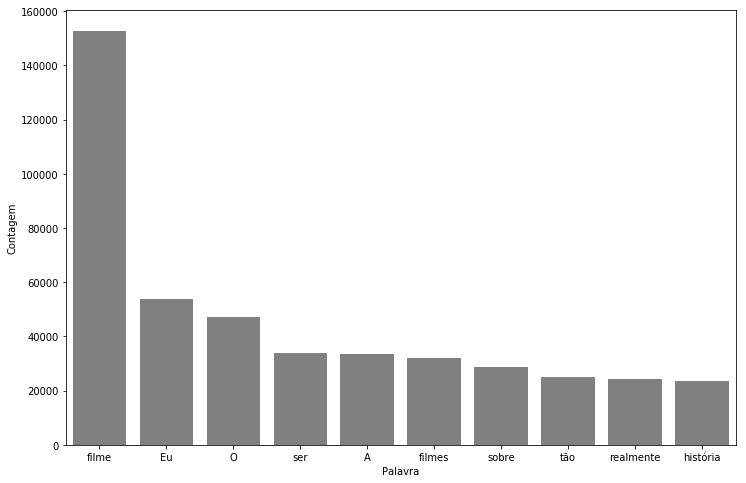

In [0]:
pareto(resenha, "tratamento_2", 10) # percebe-se que saiu o hífen '-' e entrou a palavra história

# Normalização de Textos
**Retirando a Acentuação**

In [0]:
!pip install Unidecode

     |████████████████████████████████| 245kB 2.9MB/s 


In [0]:
import unidecode 

acentos = "ótimo péssimo não é tão"

teste = unidecode.unidecode(acentos)  # retorna todas as palavras sem nenhum tipo de acento
print(teste)

otimo pessimo nao e tao


In [0]:
sem_acentos = [unidecode.unidecode(texto) for texto in resenha["tratamento_2"]]  

# a partir dos textos do ultimo tratamento, criar uma variável que conterá as palavras não acentuadas

In [0]:
sem_acentos[0]

'Mais vez Sr Costner arrumou filme tempo necessario Alem terriveis sequencias resgate mar quais poucas simplesmente importei nenhum personagens A maioria fantasmas armario personagem Costers realizado logo inicio esquecido tarde importava O personagem deveriamos importar arrogante superconfiante Ashton Kutcher O problema sai garoto pensa melhor qualquer outra pessoa redor mostra sinais armario desordenado Seu unico obstaculo parece estar vencendo Costner Finalmente bem alem meio caminho Costner conta sobre fantasmas Kutchers Somos informados Kutcher levado ser melhor pressentimentos pressagios anteriores Nenhuma magica aqui tudo podia fazer desligar hora'

In [0]:
stopwords_sem_acento = [unidecode.unidecode(texto) for texto in pontuacao_stopwords]

# Agora, retirar os acentos das stopwords. 
# Isso porque, nos tratamentos anteriores, poderia ter um "nao" sem acento que não foi retirado

In [0]:
stopwords_sem_acento

['!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~',
 'de',
 'a',
 'o',
 'que',
 'e',
 'e',
 'do',
 'da',
 'em',
 'um',
 'para',
 'com',
 'nao',
 'uma',
 'os',
 'no',
 'se',
 'na',
 'por',
 'mais',
 'as',
 'dos',
 'como',
 'mas',
 'ao',
 'ele',
 'das',
 'a',
 'seu',
 'sua',
 'ou',
 'quando',
 'muito',
 'nos',
 'ja',
 'eu',
 'tambem',
 'so',
 'pelo',
 'pela',
 'ate',
 'isso',
 'ela',
 'entre',
 'depois',
 'sem',
 'mesmo',
 'aos',
 'seus',
 'quem',
 'nas',
 'me',
 'esse',
 'eles',
 'voce',
 'essa',
 'num',
 'nem',
 'suas',
 'meu',
 'as',
 'minha',
 'numa',
 'pelos',
 'elas',
 'qual',
 'nos',
 'lhe',
 'deles',
 'essas',
 'esses',
 'pelas',
 'este',
 'dele',
 'tu',
 'te',
 'voces',
 'vos',
 'lhes',
 'meus',
 'minhas',
 'teu',
 'tua',
 'teus',
 'tuas',
 'nosso',
 'nossa',
 'nossos',
 'nossas',
 'dela',
 'delas',
 'esta',
 'estes',
 'estas',
 'aquele',
 

**Criando a coluna do 3° Tratamento**

In [0]:
resenha["tratamento_3"] = sem_acentos

frase_processada = list()
for opiniao in resenha["tratamento_3"]:
    nova_frase = list()
    palavras_texto = token_pontuacao.tokenize(opiniao)
    for palavra in palavras_texto:
        if palavra not in stopwords_sem_acento:
            nova_frase.append(palavra)
    frase_processada.append(' '.join(nova_frase))
    
resenha["tratamento_3"] = frase_processada

In [0]:
resenha.head()

,id,text_en,text_pt,sentiment,classificao,classificacao,tratamento_1,tratamento_2,tratamento_3
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg,0,0,"Mais vez, Sr. Costner arrumou filme tempo nece...",Mais vez Sr Costner arrumou filme tempo necess...,Mais vez Sr Costner arrumou filme tempo necess...
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg,0,0,Este exemplo motivo maioria filmes ação mesmos...,Este exemplo motivo maioria filmes ação mesmos...,Este exemplo motivo maioria filmes acao mesmos...
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg,0,0,"Primeiro tudo odeio raps imbecis, poderiam agi...",Primeiro tudo odeio raps imbecis poderiam agir...,Primeiro tudo odeio raps imbecis poderiam agir...
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg,0,0,Nem Beatles puderam escrever músicas todos gos...,Nem Beatles puderam escrever músicas todos gos...,Nem Beatles puderam escrever musicas todos gos...
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg,0,0,"Filmes fotos latão palavra apropriada eles, ve...",Filmes fotos latão palavra apropriada verdade ...,Filmes fotos latao palavra apropriada verdade ...


In [0]:
acuracia_tratamento3 = classificar_texto(resenha, "tratamento_3", "classificacao")
print(acuracia_tratamento3)

# última acurácia foi de 0.660735, ou seja, com esses tratamentos houve uma melhora

0.6810351799433886


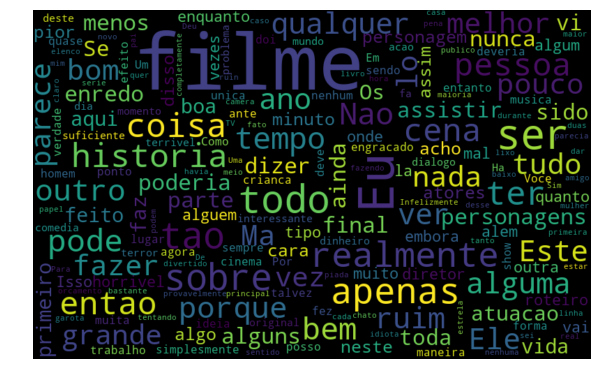

In [0]:
nuvem_palavras_neg(resenha, "tratamento_3")

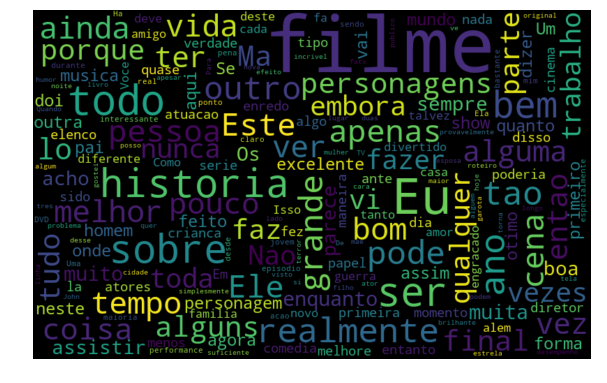

In [0]:

nuvem_palavras_pos(resenha, "tratamento_3")

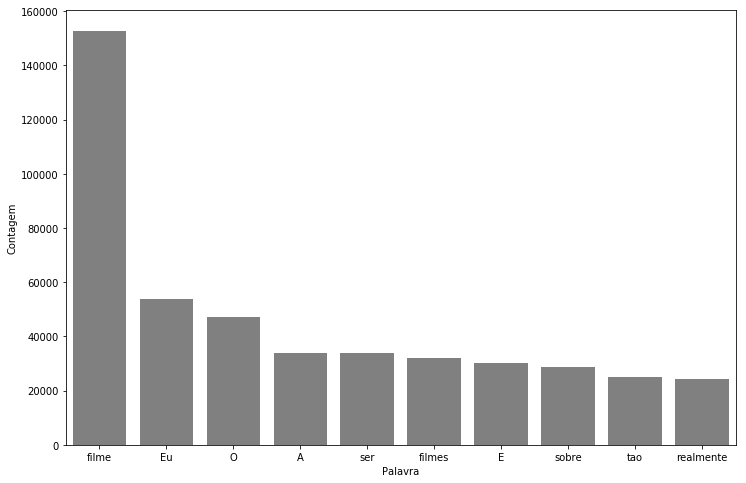

In [0]:
pareto(resenha, "tratamento_3", 10)

# Normalização de Textos
**Transformando Todas as Letras em Minúsculas**

In [0]:
frase = "O Thiago é o novo instrutor da Alura"
print(frase.lower())   # retorna todas as letras em minúsculo

o thiago é o novo instrutor da alura


In [0]:
frase_processada = list()
for opiniao in resenha["tratamento_3"]:
    nova_frase = list()
    opiniao = opiniao.lower()
    palavras_texto = token_pontuacao.tokenize(opiniao)
    for palavra in palavras_texto:
        if palavra not in stopwords_sem_acento:
            nova_frase.append(palavra)
    frase_processada.append(' '.join(nova_frase))
    
resenha["tratamento_4"] = frase_processada

In [0]:
resenha["tratamento_4"][0]

'vez sr costner arrumou filme tempo necessario alem terriveis sequencias resgate mar quais poucas simplesmente importei nenhum personagens maioria fantasmas armario personagem costers realizado logo inicio esquecido tarde importava personagem deveriamos importar arrogante superconfiante ashton kutcher problema sai garoto pensa melhor qualquer outra pessoa redor mostra sinais armario desordenado unico obstaculo parece estar vencendo costner finalmente bem alem meio caminho costner conta sobre fantasmas kutchers informados kutcher levado ser melhor pressentimentos pressagios anteriores nenhuma magica aqui tudo podia fazer desligar hora'

In [0]:
acuracia_tratamento4 = classificar_texto(resenha, "tratamento_4", "classificacao")
print('Tratamento 3: %f'%acuracia_tratamento3)
print('Tratamento 4: %f'%acuracia_tratamento4)

#percebe-se a pequena melhora da acurácia do tratamento 3 para o 4

Tratamento 3: 0.681035
Tratamento 4: 0.687909


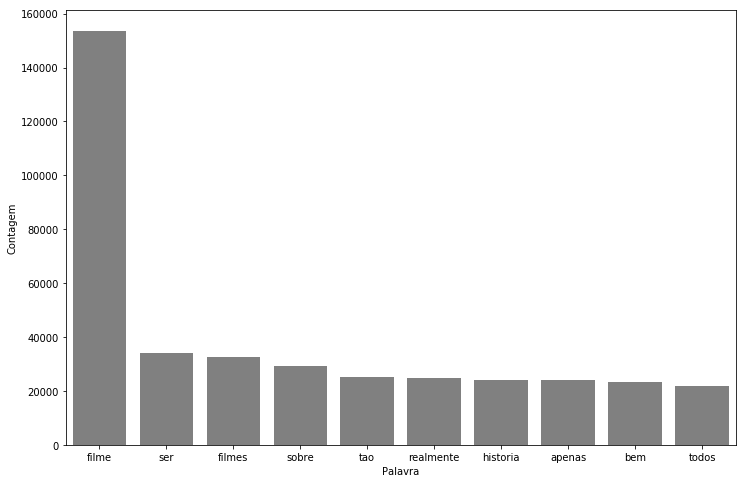

In [0]:
pareto(resenha, "tratamento_4", 10)   

# percebe-se que saiu as palavras O, A, E, Eu, e entrou algumas palavras mais relevantes

# Evitando Flexões e Derivações nas Palavras

**Exemplo Simples**

In [0]:
# O processo de reduzir os elementos a um radical comum é chamado de "stemização

stemmer = nltk.RSLPStemmer()   # RLSP - Removedor de Sufixos da Lingua Portuguesa
stemmer.stem("corredor")

'corr'

In [0]:
# aplicando o stemmer a partir das resenhas do tratamento 4
# esse tratamento demora mais que os outros para ser feito

frase_processada = list()
for opiniao in resenha["tratamento_4"]:
    nova_frase = list()
    palavras_texto = token_pontuacao.tokenize(opiniao)
    for palavra in palavras_texto:
        if palavra not in stopwords_sem_acento:
            nova_frase.append(stemmer.stem(palavra))
    frase_processada.append(' '.join(nova_frase))
    
resenha["tratamento_5"] = frase_processada   # criando mais uma coluna de tratamento

In [0]:
acuracia_tratamento5 = classificar_texto(resenha, "tratamento_4", "classificacao")
print('Tratamento 4: %f'%acuracia_tratamento4)
print('Tratamento 5: %f'%acuracia_tratamento5)

Tratamento 4: 0.687909
Tratamento 5: 0.687909


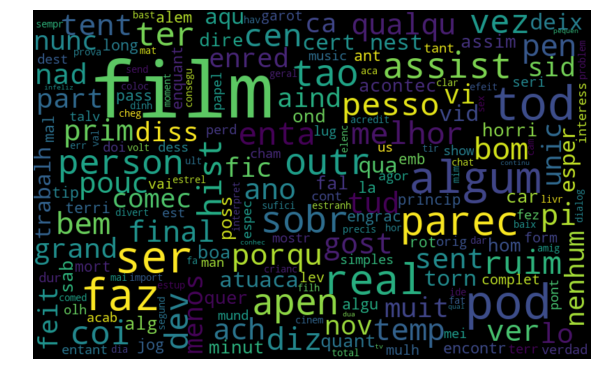

In [0]:
nuvem_palavras_neg(resenha, "tratamento_5")

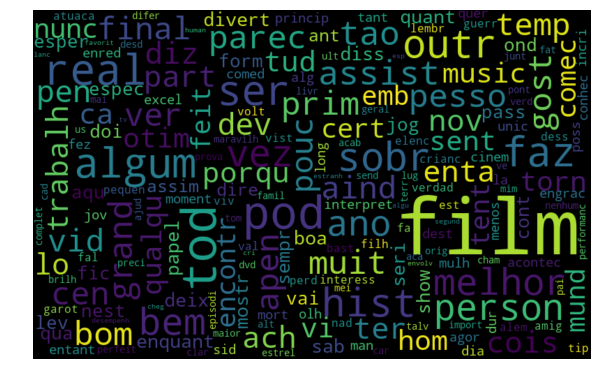

In [0]:
nuvem_palavras_pos(resenha,"tratamento_5")

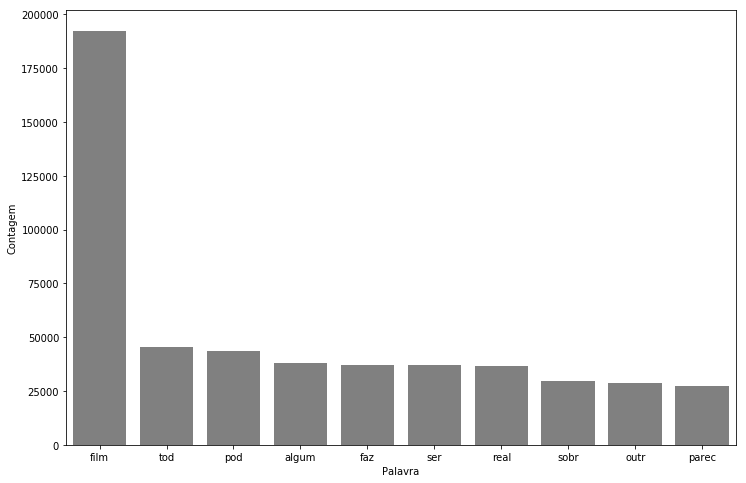

In [0]:
pareto(resenha, "tratamento_5", 10)

# TF-IDF e Ngrams: Técnicas mais Avançadas
**TF-IDF (Frequência dos Termos - Inverso da Frequência do Documento)**

In [0]:
#  Conceito de atribuir pesos às palavras mais importante do nosso conjunto de dados

from sklearn.feature_extraction.text import TfidfVectorizer

frases = ["Assiti um filme ótimo", "Assiti um filme péssimo"]  # Exemplo simples

tfidf = TfidfVectorizer(lowercase=False, max_features=50)  

caracteristicas = tfidf.fit_transform(frases)   # vetorizar as frases com o TfidfVectorizer
pd.DataFrame(                                   # transformar em um DF
    caracteristicas.todense(),                  # transforma os dados esparsos em um matriz convencional na qual os zeros serão representados
    columns=tfidf.get_feature_names()
)      

,Assiti,filme,péssimo,um,ótimo
0,0.448321,0.448321,0.000000,0.448321,0.630099
1,0.448321,0.448321,0.630099,0.448321,0.000000


In [0]:
# aplicar o Tfidf 1° ao texto bruto (sem tratamentos)

tfidf_bruto = tfidf.fit_transform(resenha["text_pt"])
treino, teste, classe_treino, classe_teste = train_test_split(tfidf_bruto,       #  # mudar para o tfidf bruto
                                                              resenha["classificacao"],
                                                              random_state = 42)
regressao_logistica.fit(treino, classe_treino)
acuracia_tfidf_bruto = regressao_logistica.score(teste, classe_teste)
print(acuracia_tfidf_bruto)

0.6601698342094622


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
# aplicar agora ao tratamento_5 (o último)

tfidf_tratados = tfidf.fit_transform(resenha["tratamento_5"])
treino, teste, classe_treino, classe_teste = train_test_split(tfidf_tratados,    # mudar para o tfidf tratado
                                                              resenha["classificacao"],
                                                              random_state = 42)
regressao_logistica.fit(treino, classe_treino)
acuracia_tfidf_tratados = regressao_logistica.score(teste, classe_teste)
print(acuracia_tfidf_tratados)

0.6987464617873028


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
print(acuracia_tratamento5)

# Logo o tfidf mostra um resultado melhor

0.6879094217549535


**Exemplo Simples de Ngrams**

In [0]:
# Esse conceito irá reforçar no no texto algumas palavras importantes, além de manter uma estrutura sequencial (seja ela de duas ou três palavras). 
# Porém, manter isso tem um custo: se temos uma frase vetorizada com 50 dimensões, por exemplo, 
# vamos dobrar essas dimensões utilizando o Ngrams, chegando em 100 dimensões.

from nltk import ngrams

frase = "Assisti um ótimo filme."
frase_separada = token_espaco.tokenize(frase)
pares = ngrams(frase_separada, 2)   # se passarmos 2 equivale a um bigrama
list(pares) # transforma em uma lista de pares

[('Assisti', 'um'), ('um', 'ótimo'), ('ótimo', 'filme.')]

**Usando Ngrams no Tratamento 5**

In [0]:
tfidf = TfidfVectorizer(lowercase=False, ngram_range = (1,2)) # estamos definindo que queremos que o vetor contenha palavras isoladas e palavras em bigramas
vetor_tfidf = tfidf.fit_transform(resenha["tratamento_5"])    
# não limitou-se as posições desse vetor (com o max_features), pois quero realizar um teste com o vetor no tamanho máximo

treino, teste, classe_treino, classe_teste = train_test_split(vetor_tfidf,  # passar o vetor_tfidf
                                                              resenha["classificacao"],
                                                              random_state = 42)
regressao_logistica.fit(treino, classe_treino)
acuracia_tfidf_ngrams = regressao_logistica.score(teste, classe_teste)
print(acuracia_tfidf_ngrams)

# Um resultado bem expressivo, porém, não pode-se comparar efetivamente esse resultado com o anterior, 
# Já que não limitou-se esse vetor a 50 dimensões

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8858875859280226


In [0]:
# Para comparar efetivamente roda-se o meesmo código sem os Ngrams

tfidf = TfidfVectorizer(lowercase=False)
vetor_tfidf = tfidf.fit_transform(resenha["tratamento_5"])
treino, teste, classe_treino, classe_teste = train_test_split(vetor_tfidf,
                                                              resenha["classificacao"],
                                                              random_state = 42)
regressao_logistica.fit(treino, classe_treino)
acuracia_tfidf = regressao_logistica.score(teste, classe_teste)
print(acuracia_tfidf)

# São resultados relativamente próximos, mas um pouco melhor com os Ngrams

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.884270117266478


In [0]:
# A regressão logística nos permite é analisar quais palavras têm maior peso na diferenciação entre as classes 
# e o que o algoritmo está entendendo como palavras negativas ou positivas


pesos = pd.DataFrame(   # cria um novo DF
    regressao_logistica.coef_[0].T, # passa os pesos de cada termo 
    index = tfidf.get_feature_names()  # como índice
)

pesos.nlargest(10,0)  # 10 maiores pesos da coluna 0

,0
otim,8.294114
excel,7.978964
perfeit,6.577950
favorit,5.778405
maravilh,5.286375
incri,5.050873
hilari,4.656836
divert,4.582136
ador,4.422483
brilh,4.268905


In [0]:
pesos.nsmallest(10,0)   # 10 menores pesos da coluna 0

,0
pi,-9.177134
ruim,-9.170209
horri,-8.752838
terri,-7.187796
chat,-6.918661
nad,-6.031082
infeliz,-5.308775
decepca,-4.999406
ridicul,-4.951710
nenhum,-4.920641
